This is the Implementation of Generative Adversarial Networks on the Fashion mnist Dataset for Generating Images

Reference: https://github.com/nicknochnack/GANBasics/blob/main/FashionGAN-Tutorial.ipynb

In [1]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import keras
import pandas

2024-05-07 01:07:24.591596: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 01:07:24.931055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 01:07:25.996446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

2024-05-07 01:07:27.427038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 01:07:28.119002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-07 01:07:28.119237: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
df=pandas.DataFrame(ds)
df.head()

2024-05-07 01:07:37.529939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,image,label
0,"(((tf.Tensor(0, shape=(), dtype=uint8)), (tf.T...","tf.Tensor(2, shape=(), dtype=int64)"
1,"(((tf.Tensor(0, shape=(), dtype=uint8)), (tf.T...","tf.Tensor(1, shape=(), dtype=int64)"
2,"(((tf.Tensor(0, shape=(), dtype=uint8)), (tf.T...","tf.Tensor(8, shape=(), dtype=int64)"
3,"(((tf.Tensor(0, shape=(), dtype=uint8)), (tf.T...","tf.Tensor(4, shape=(), dtype=int64)"
4,"(((tf.Tensor(0, shape=(), dtype=uint8)), (tf.T...","tf.Tensor(1, shape=(), dtype=int64)"


<h2> Data Visualisation

In [4]:
import numpy as np

In [5]:
dataiterator = ds.as_numpy_iterator()

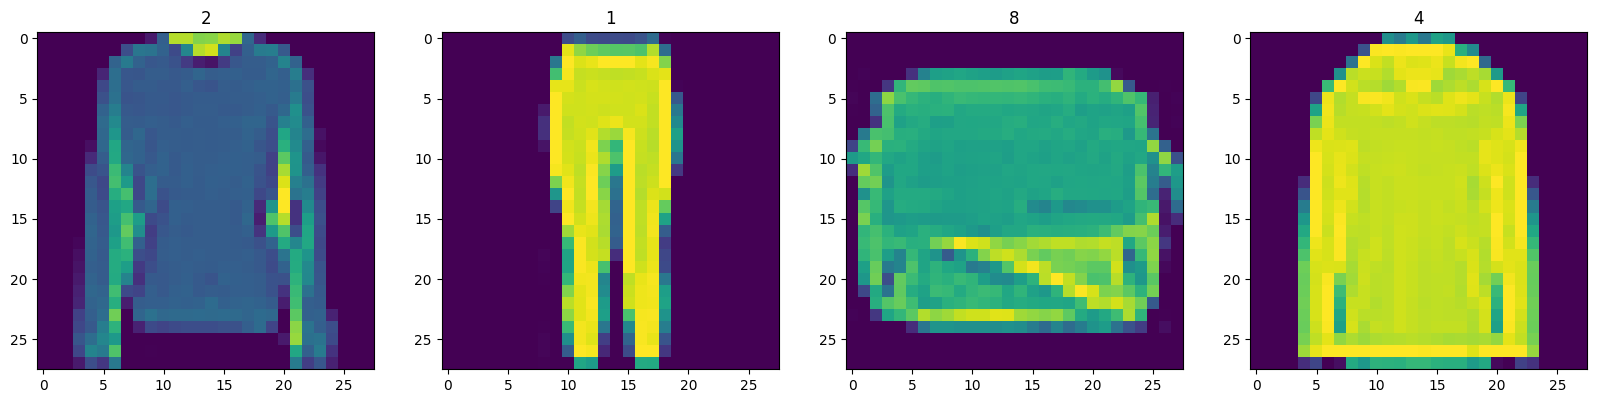

In [6]:
fig,ax= plt.subplots(ncols=4,figsize=(20,20))

for idx in range(4):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image'])) #np.squeeze is used to convert 28 x 28 x 1 images to 28 x 28 image
    ax[idx].title.set_text(batch['label'])

In [7]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [8]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [9]:

ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

<h3>Building Generator

In [10]:
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [11]:
def build_generator():
    model=Sequential()

    model.add(Dense(7*7*128,input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    

    model.add(UpSampling2D())
    model.add(Conv2D(128,5,padding="same"))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model


In [12]:
generator = build_generator()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
img = generator.predict(np.random.randn(4,128,1))

I0000 00:00:1715044066.151933    2851 service.cc:145] XLA service 0x7f9d480056e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715044066.152230    2851 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-07 01:07:46.215321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-07 01:07:46.361513: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1715044067.891485    2851 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


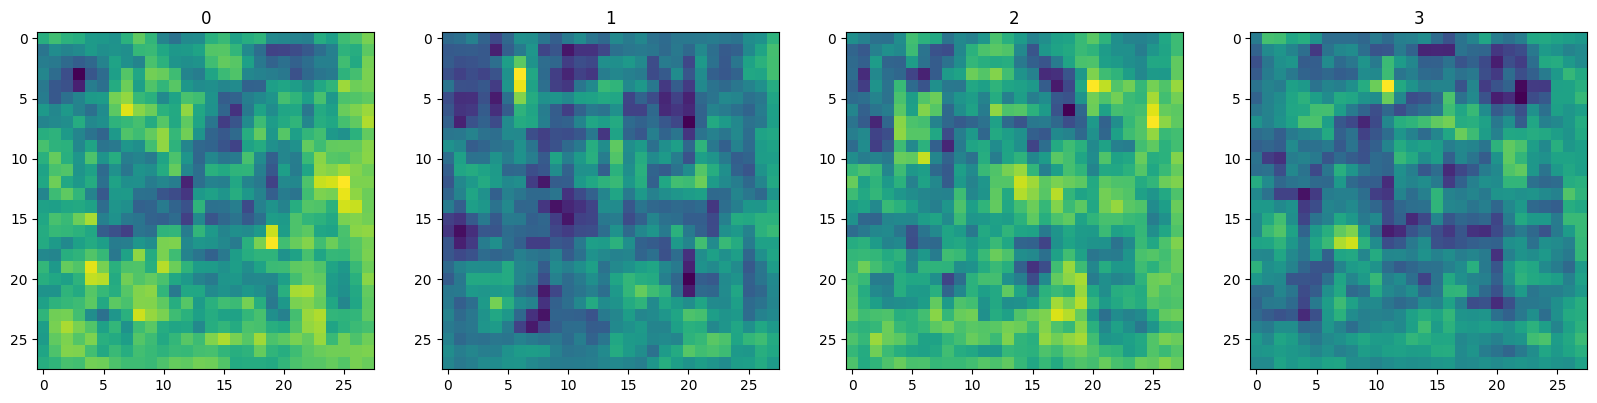

In [15]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

<h3>Building Discriminator

In [16]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [17]:
discriminator = build_discriminator()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

<h3>Training the Model

In [19]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [20]:

g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

<h3>Constructing the training Loop

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model

In [29]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [30]:

# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [31]:

# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [32]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [33]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [35]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 92s 196ms/step - d_loss: 0.3572 - g_loss: 3.5015
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 198ms/step - d_loss: 0.2870 - g_loss: 7.9484
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 198ms/step - d_loss: 0.3211 - g_loss: 7.3685
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 199ms/step - d_loss: 0.6821 - g_loss: 0.7324
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 199ms/step - d_loss: 0.6430 - g_loss: 0.6639
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 199ms/step - d_loss: 0.7034 - g_loss: 0.5031
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 199ms/step - d_loss: 0.6880 - g_loss: 0.6408
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 199ms/step - d_loss: 0.6860 - g_loss: 0.6187
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 199ms/step - d_loss: 0.6742 - g_loss: 0.6496
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 199ms/step - d_loss: 0.6991 - g_loss: 0.6008
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 199ms/step - d_loss: 0.6966 - g_loss: 0.6393
Epoch 12/20
469/469

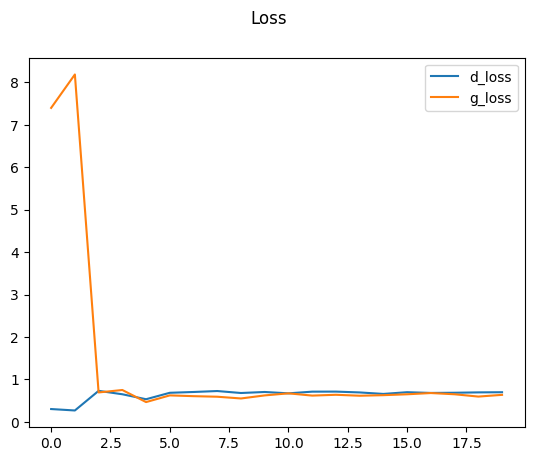

In [36]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [51]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


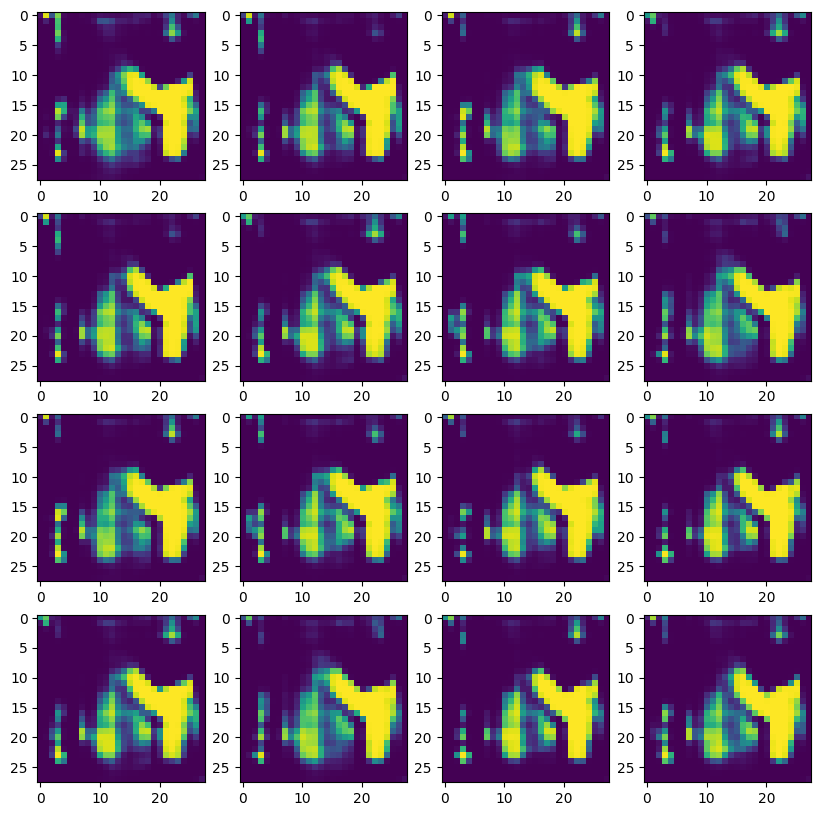

In [52]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])